# Contour extraction algorithm

Author: Severin Kaderli, University of Bern, severin.kaderli@students.unibe.ch

This algorithm is designed to extract (closed) contours of 2D gridded data. <br />
A xarray data set including the dimensions lat, lot at a specific time step serves as an input. <br />
The following features are implemented in the algorithm: <br />
* Extraction of all contours with a given value. Unconnected contour parts are stored separately.
* Rescaling of the contour to the resolution of the input data set. Due to interpolation of the contour extraction tool, the resolution of the original contours is higher.
* Grouping of unclosed contours based on the start and end point. This is especially needed if overturning of the contour is present over the date border.
* The focus of the algorithm lies in identifying the largest contour enclosing the pole. Therefore the algorithm includes a filtering feature, which can be used to drop contours smaller than a certain threshold. The size of a contour is defined by the expansion of the contour in the longitudinal direction.
* Since in many usecases only the largest contour is of interest, the algorihm includes an option to drop all contours but the largest.

This work including the Rossby wave breaking detection algorithms which use the extracted contour as an input are based and inspired by the work of Wernli and Sprenger (2007) and Barnes (2012).

## Preperations

### import packages

In [1]:
# for data
import xarray as xr

# for algorithm
import numpy as np
import itertools as itertools
from skimage import measure
from scipy import spatial
import pandas as pd

# for plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns

### load data

In [2]:
# load data
path = "/home/steidani/scratch3/data/era5/isen/ERA5_daily_PV_1_deg_330K_1979-2019.nc"
ds = xr.open_dataset(path)
ds

<xarray.Dataset>
Dimensions:  (lon: 360, lat: 90, time: 14975)
Coordinates:
  * lon      (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 177.0 178.0 179.0
  * lat      (lat) float64 0.0 1.0 2.0 3.0 4.0 5.0 ... 85.0 86.0 87.0 88.0 89.0
  * time     (time) int32 1 2 3 4 5 6 7 ... 14970 14971 14972 14973 14974 14975
Data variables:
    pv       (time, lat, lon) float32 ...

In [3]:
# specify names of coordinates
lat_name = "lat"
lon_name = "lon"
time_name = "time"
var_name = "pv"

### pre-process data

In [4]:
# run this cell if...
# time units are just time steps 1,2,3,... --> replace time steps with actual dates
ds[time_name].attrs["units"] = "days since 1978-12-31"
ds = xr.decode_cf(ds)

In [5]:
# run this cell if...
# you want to slice your dataset to reduce the size of your dataset
ds = ds.isel({time_name:slice(0,100)})

In [6]:
# get lon border
lon_border = [int(ds[lon_name].values.min()), int(ds[lon_name].values.max())]

In [7]:
# run this cell if...
# you want to add a wrap-around longitude to your dataset.
# add the first column (longitude) after the last column of your dataset.
# better results can be achieved if the first and last column contain the same data
overlap = ds.sel({lon_name:min(lon_border)})
overlap[lon_name].values = max(lon_border)+1
ds = xr.concat([ds,overlap],dim=lon_name)

#update lon_border
lon_border[1] += 1

## Components of the contour extracting algorithm

### parameters contour extracting algorithm
* "level": Specify the value of the contour
* "x_expansion": Specify min expansion of a single contour. A value of 1 means that the contour is present over all entered longitudes.
* "y_overlap": Specify in which interval (in degrees) in the y direction unclosed contours should be grouped together as long as they share the same longitude. Unclosed contours occur for example due to overturning at date border.
* "single": Specify if you only want to keep one (the largest) contour.
* "scale": Specify if the resolution of the contour points should be scaled to the resolution of the input field.

In [8]:
# enter algorithm parameters
level = 2 # for this dataset in potential vorticity units
x_expansion = 0.3 # in percentage
y_overlap = 2 # in degrees
single = True
scale = True

### define the different components

In [9]:
def contours_extract(dataset, level):
    """
    The algorithm bases on the "find_contours" function of "measure" by "skimage".
    The output of the "find_contours" function needs to modified in order to get back the original coordinates.
    The final output contains a list where the every entry represents a single detected contour.
    Input: xarray.Dataset and contour level
    Output: List with arrays (lon,lat) representing the different contour lines
    """
    return [np.c_[contour[:,1]+min(lon_border),contour[:,0]] for contour in measure.find_contours(dataset[var_name].values,level)]

In [10]:
def rescale_contours(contours, dataset):
    """
    Rescale the coordinates of the contour points. 
    The coordinates are fitted on a grid with the same resolution as the input field
    Input: A contour in form of a list with arrays (lon,lat) and the xarray.Dataset
    Ouput: List with arrays (lon,lat) representing the different contour lines
    """
    x, y = np.meshgrid(dataset[lon_name],dataset[lat_name]) 
    x, y = x.flatten(), y.flatten()
    grid_points = np.vstack((x,y)).T 
    tree = spatial.KDTree(grid_points)

    contours_scaled = []
    for contour in contours:
        temp = []
        for point in contour:
            temp.append(grid_points[tree.query([point])[1][0]])
        unique = list(dict.fromkeys(map(tuple,temp)))
        contours_scaled.append(np.asarray(unique))
            
    return contours_scaled

In [11]:
def group_contours(contours,y_overlap):
    """
    Group the contours according to their start and end point.
    Using the parameter "y_overlap" (in degree), the interval represeting the overlap region can be specified.
    In addition, in the x direction are allowed to be up to 2 degrees apart from each other. This ensures grouping over the date border.
    Input: A contour in form of a list with arrays (lon,lat) and the parameter y_overlap in degrees.
    Ouput: List with arrays (lon,lat) representing the different contour lines
    """
    contours_index = list(range(0,len(contours)))
    borders = []
    for contour,index in zip(contours,contours_index):
        stp = contour[0].tolist()
        ndp = contour[-1].tolist()
        borders.append([index]+stp+ndp)

    start = [[border[1],border[2]] for border in borders]
    end = [[border[3],border[4]] for border in borders]
    both = start+end
    
    for point in both:
        ind = [i for i, x in enumerate(both) if (x[0]==point[0] or all(i in [x[0],point[0]] for i in lon_border)) and point[1]-y_overlap <= x[1] <= point[1]+y_overlap]
        ind = np.mod(ind,len(contours))
        add = [borders[i][0] for i in ind]
        for i in ind:
            borders[i][0] = borders[min(add)][0]    

    all_values = [border[0] for border in borders]
    unique_values = set(all_values)

    contours_grouped = []
    for value in unique_values:
        this_group = []
        for border,contour in zip(borders,contours):
            if border[0] == value:
                this_group.append(contour)
        contours_grouped.append(this_group)
    
    contours_grouped_sorted = []
    for group in contours_grouped:
        if len(group) > 1:
            bigest = sorted(group, key=len, reverse=True)[0]
            rest = sorted(group, key=len, reverse=True)[1:]

            temp = [bigest]
            while len(rest) > 0:
                test = temp[-1][-1,1]
                for item,ind in zip(rest, range(0,len(rest))):
                    if test-y_overlap <= item[0,1] <= test+y_overlap:
                        temp.append(item)
                        break
                del rest[ind]
            contours_grouped_sorted.append(np.asarray(list(itertools.chain.from_iterable(temp))))
        else:
            contours_grouped_sorted.append(np.asarray(list(itertools.chain.from_iterable(group))))
            
        
    return contours_grouped_sorted

In [12]:
def filter_contours(contours, dataset, x_expansion):
    """
    The contours are filtered in respect to the previoulsy defined parameter "x_expansion".
    Input: A contour in form of a list with arrays (lon,lat), the xarray.Dataset and the parameter x_expansion in percent
    Ouput: List with arrays (lon,lat) representing the different contour lines
    """
    lons = dataset[lon_name].values
    contour_expansion = [len(np.unique(np.round(contour[:,0]))) for contour in contours]
    test_expansion = [expansion/len(lons) >= x_expansion for expansion in contour_expansion]
    
    return list(itertools.compress(contours, test_expansion))

In [13]:
def single_contours(contours, dataset, x_expansion):
    """
    For some applications it is useful only to keep the largest contour.
    If there are two contours completely enclosing the pole, the contour with the smaller mean latitude is kept.
    Input: A contour in form of a list with arrays (lon,lat), the xarray.Dataset and the parameter x_expansion in percent
    Ouput: An array (lon,lat) representing the different contour lines
    """
    lons = dataset[lon_name].values
    contour_expansion = [len(np.unique(np.round(contour[:,0]))) for contour in contours]
    test_expansion = [expansion/len(lons) >= x_expansion for expansion in contour_expansion]

    if sum([i==1 for i in contour_expansion])>1: 
        mean_lat = [np.mean(contour[:,1]) for contour in contours]
        contours_single = contours[mean_lat.index(min(mean_lat))]
    else: 
        contours_single = contours[test_expansion.index(max(test_expansion))]

    return contours_single

In [14]:
def df_contours(contours):
    """
    Store final contour in a pandas data frame
    Input: A contour in form of a list with arrays (lon,lat) or in form of an array (lon,lat)
    Output: A dataframe with the columns lon and lat
    """
    if type(contours)=="list":
        temp = np.asarray(list(itertools.chain.from_iterable(contours)))
    else:
        temp = contours
    return pd.DataFrame({'lon': temp[:,0].tolist(), 'lat': temp[:,1].tolist()})

### plot every process step for one time step

In [15]:
dataset = ds.isel({time_name:0})

contours = contours_extract(dataset, level)
contours_scaled = rescale_contours(contours, dataset)
contours_grouped = group_contours(contours_scaled, y_overlap)
contours_filtered = filter_contours(contours_grouped, dataset, x_expansion)
contours_single = single_contours(contours_filtered, dataset, x_expansion)

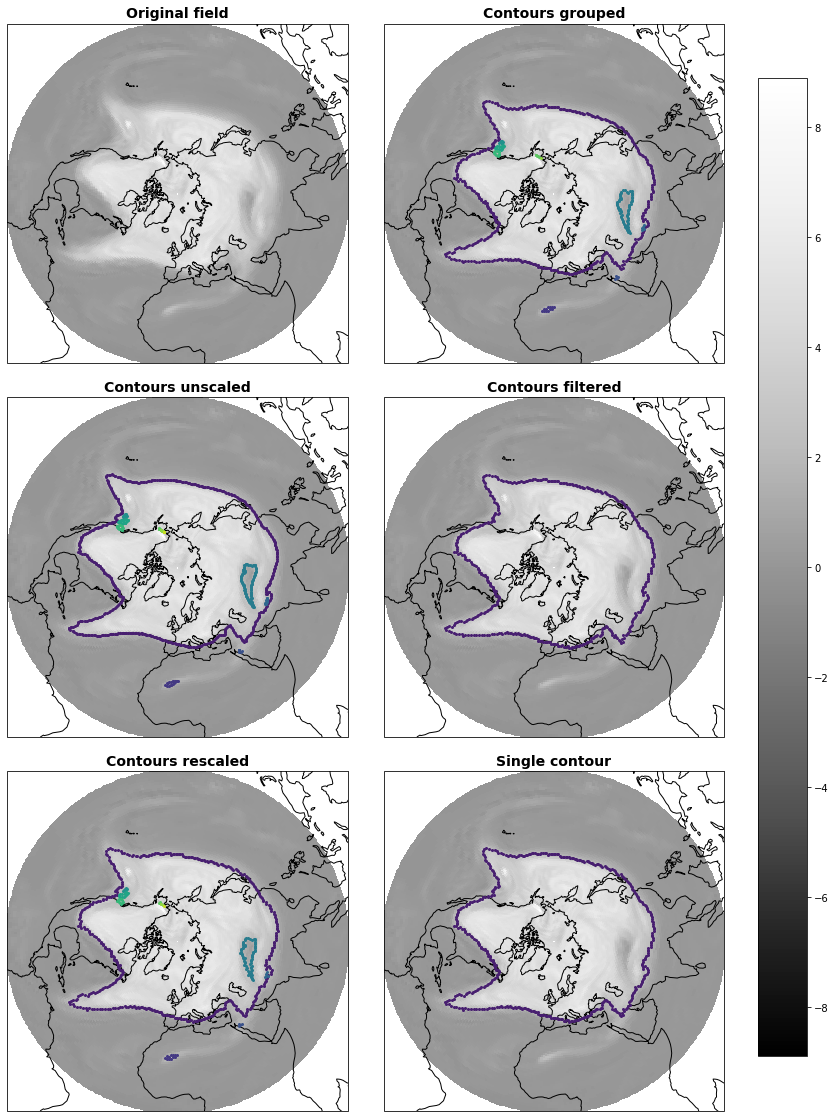

In [16]:
data_crs = ccrs.PlateCarree()
proj = ccrs.NorthPolarStereo()

fig, axes = plt.subplots(3,2, subplot_kw=dict(projection=proj), figsize=(20,20))

pal_contours = "viridis"
colors = sns.color_palette(pal_contours, n_colors=len(contours))

line_wd = 2

for ax in axes.flat:
    ax.add_feature(cfeature.COASTLINE)
    ax.set_extent([-180, 180, 0, 89], crs=data_crs)
    p0 = dataset[var_name].plot(ax=ax, cmap="Greys_r", add_colorbar=False, transform=data_crs)

data = [contours_grouped,contours, contours_filtered, contours_scaled, [contours_single]]
for ax,item in zip(axes.flat[1:],data):
    for contour, color in zip(item,colors):
        ax.plot(contour[:, 0], contour[:, 1], ".", markersize=4, linewidth=line_wd, color = color, transform=data_crs)
    
cbar = plt.colorbar(p0, ax=axes.flat, shrink=0.9)

titles = ["Original field",
          "Contours grouped",
          "Contours unscaled",
          "Contours filtered",
          "Contours rescaled",
          "Single contour"]

for ax,title in zip(axes.flat,titles):
    ax.set_title("")
    ax.set_title(title, fontweight='bold',fontsize=14, loc='center')

plt.subplots_adjust(wspace = -0.3, hspace=0.1, right = 0.76)

## Combine all subfunctions to one algorithm

In [17]:
def extract_contour(dataset, level, y_overlap, x_expansion, single, scale):
    
    """
    This function combines all the subfuncitons mentioned above.
    The output is a dataframe with the columns lon and lat.
    """
    
    contours = contours_extract(dataset, level)
    if scale == True:
        contours_scaled = rescale_contours(contours, dataset)
    else:
        contours_scaled = contours

    contours_grouped = group_contours(contours_scaled, y_overlap)
    contours_filtered = filter_contours(contours_grouped, dataset, x_expansion)
    if single == True:
        contours_return = single_contours(contours_filtered, dataset, x_expansion)
    else:
        contours_return = contours_filtered
    
    return df_contours(contours_return)

### create simple plot for one time step

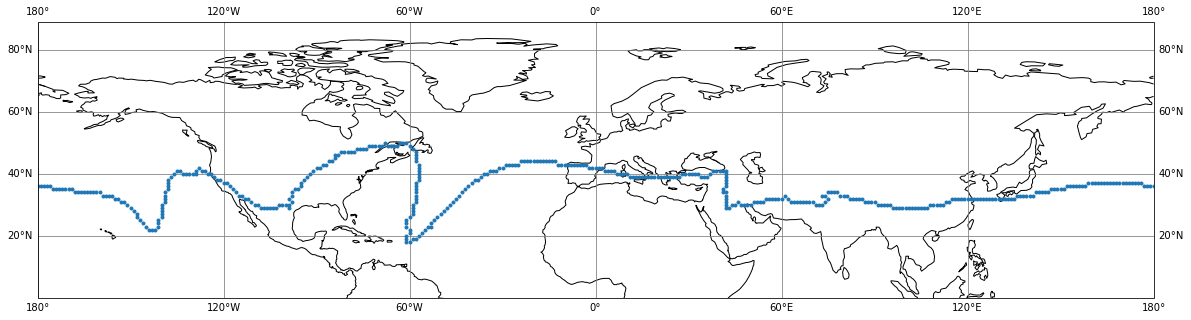

In [18]:
dataset = ds.isel({time_name:0})
result = extract_contour(dataset, level, y_overlap, x_expansion, single, scale)

data_crs = ccrs.PlateCarree()
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=[20,10])
ax = plt.axes(projection=proj)

ax.plot(result["lon"], result["lat"], ".")

ax.set_extent([-180, 180, 0, 89], crs=data_crs)
ax.add_feature(cfeature.COASTLINE)
ax.gridlines(draw_labels=True, color="gray")

plt.show()

## Store contour in an array

In [19]:
def array_contours(contours):
    """
    This function stores a contour in array of the same dimension as the input data.
    The grid cells containing the contour are marked with a 1, the rest has the value 0. 
    Input: An array (lon,lat)
    """
    data_array = np.zeros([len(dataset[lat_name]),len(dataset[lon_name])])
    for index,row in contours.iterrows():
        data_array[int(row["lat"]),int(row["lon"])+min(lon_border)] = 1
    return data_array

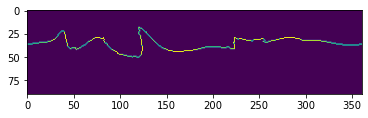

In [20]:
dataset = ds.isel({time_name:0})
result = extract_contour(dataset, level, y_overlap, x_expansion, single, scale)

plt.imshow(array_contours(result))
#be aware the contour is reversed due to the plotting method

## Apply algorithm on several time steps and store contours in xarray.Dataset

In [21]:
dataset = ds.isel({time_name:slice(0,50)})

In [22]:
times = dataset[time_name]
result_contours = [extract_contour(dataset.sel({time_name:time}), level, y_overlap, x_expansion, single, scale) for time in times]
result_arrays = [array_contours(extract_contour(dataset.sel({time_name:time}), level, y_overlap, x_expansion, single, scale)) for time in times]

dataset["contour"] = ((time_name,lat_name, lon_name), result_arrays)

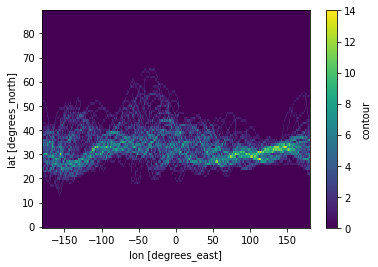

In [23]:
dataset.contour.sum(dim="time").plot()

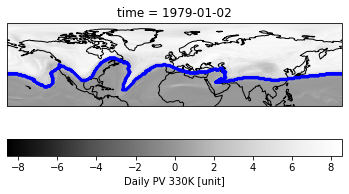

In [24]:
# plot pv and contour for one time step
ax = plt.axes(projection = ccrs.PlateCarree())
dataset.pv.isel({time_name:1}).plot(transform = ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal'}, cmap="Greys_r")
dataset.contour.isel({time_name:1}).plot.contour(transform = ccrs.PlateCarree(), colors="blue")
ax.coastlines()
ax.set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree())

In [25]:
# Save dataset
output_path = "output/"
dataset["contour"].to_netcdf(output_path+"contour.nc")

## Store data frame result as csv
Each time step is stored as a single .csv file


In [26]:
output_path = "output/"

dataset = ds.isel({time_name:slice(0,5)})
times = dataset[time_name]
for time in times:
    temp = extract_contour(dataset.sel({time_name:time}), level, y_overlap, x_expansion, single, scale)
    temp.to_csv(output_path+str(pd.to_datetime(time.values).strftime("%Y-%m-%d"))+".csv",index=False)